마스크 데이터셋을 읽고 전처리를 진행한 후 데이터를 하나씩 꺼내주는 Dataset 클래스를 구현한 파일입니다.

이 곳에서, 나만의 Data Augmentation 기법 들을 구현하여 사용할 수 있습니다.

In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models as models
from PIL import Image

In [2]:
get_data = pd.read_csv(r'/opt/ml/data/train/train.csv')
get_data = get_data.drop(['race','id'],axis=1)
get_data

,gender,age,path
0,female,45,000001_female_Asian_45
1,female,52,000002_female_Asian_52
2,male,54,000004_male_Asian_54
3,female,58,000005_female_Asian_58
4,female,59,000006_female_Asian_59
...,...,...,...
2695,male,19,006954_male_Asian_19
2696,male,19,006955_male_Asian_19
2697,male,19,006956_male_Asian_19
2698,male,20,006957_male_Asian_20


In [3]:
get_data.values

array([['female', 45, '000001_female_Asian_45'],
       ['female', 52, '000002_female_Asian_52'],
       ['male', 54, '000004_male_Asian_54'],
       ...,
       ['male', 19, '006956_male_Asian_19'],
       ['male', 20, '006957_male_Asian_20'],
       ['male', 19, '006959_male_Asian_19']], dtype=object)

In [4]:
DIR_ROOT = r'/opt/ml/data/train/images/'
target = get_data.values
image_locate = [DIR_ROOT + i for i in get_data['path']]
images = []
for i in image_locate:
    temp = []
    for j in os.listdir(i):
        if not j[0] == '.':
            temp.append(i+'/'+j)
    images.append(temp)
images[:2]


[['/opt/ml/data/train/images/000001_female_Asian_45/mask3.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask4.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask1.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask5.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask2.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/normal.jpg'],
 ['/opt/ml/data/train/images/000002_female_Asian_52/mask3.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask4.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/incorrect_mask.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask1.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask5.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask2.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/normal.jpg']]

In [5]:
label_data = []
file_name_string = 'min'
labeled_dict = {"label": [],
                "gender": [],
                "age": [],
                "locate": []}
for i in images:
    for j in i:
        #/opt/ml/data/train/images/000002_female_Asian_52/normal.jpg 자른 것
        get_locate_file = j.split('/')
        #가장 끝의 파일은 이미지 이름이다.
        label = file_name_string.index(get_locate_file[-1][0])
        start = label * 6
        #000002_female_Asian_52 잘라서 굳이 위에 선언한 데이터 불러오지 않고 수행
        _, sex, _, age = get_locate_file[-2].split('_')
        age = int(age)
        if sex == 'female':
            start +=3
        if age < 30:
            pass
        elif age < 60:
            start +=1
        else:
            start +=2
        labeled_dict['label'].append(start)
        labeled_dict['gender'].append(sex)
        labeled_dict['age'].append(age)
        labeled_dict['locate'].append(j)

labeled_dict = pd.DataFrame(labeled_dict, columns=labeled_dict.keys())
labeled_dict

,label,gender,age,locate
0,4,female,45,/opt/ml/data/train/images/000001_female_Asian_...
1,4,female,45,/opt/ml/data/train/images/000001_female_Asian_...
2,10,female,45,/opt/ml/data/train/images/000001_female_Asian_...
3,4,female,45,/opt/ml/data/train/images/000001_female_Asian_...
4,4,female,45,/opt/ml/data/train/images/000001_female_Asian_...
...,...,...,...,...
18895,6,male,19,/opt/ml/data/train/images/006959_male_Asian_19...
18896,0,male,19,/opt/ml/data/train/images/006959_male_Asian_19...
18897,0,male,19,/opt/ml/data/train/images/006959_male_Asian_19...
18898,0,male,19,/opt/ml/data/train/images/006959_male_Asian_19...


18900
12


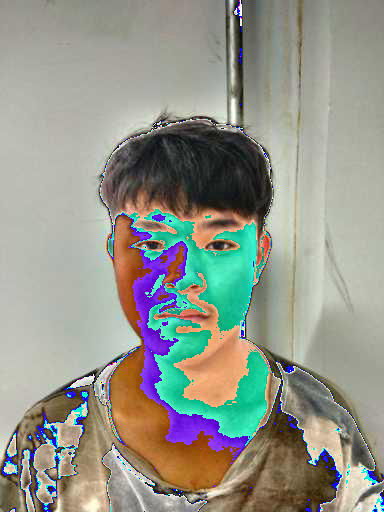

In [7]:
class MaskDataset(Dataset):
    def __init__(self, data, transform= None):
        self.data = data
        self.classes = ['label', 'gender', 'age', 'locate']
        self.transform = transform

    def __len__(self):
        return (len(self.data))

    def __getitem__(self, idx):
        X = Image.open(self.data['locate'].iloc[idx])
        y = self.data['label'].iloc[idx]
        if self.transform is not None:
            X = self.transform(X)

        return X,y

datasets = MaskDataset(labeled_dict, 
transforms.Compose([
    # 선형 보간법을 사용하여 출력 픽셀값을 계산 -> 부드러운 느낌을 준다는데 누구 기준인진 잘
    transforms.Resize((512,384), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    ])
)

print(len(datasets))
#tuple 로 반환하는거 확인
img,lb = datasets[18899]
print(lb)
im_pil = transforms.ToPILImage()(img)
im_pil


In [10]:
# 이거 안하면 마지막 인덱스에 붙어 나와서 서로 다른 인덱스로 잘라서 넣어주기 위함임
def collate_function(data : tuple):
    return tuple(zip(*data))

data_loader = DataLoader(datasets, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_function)
print(next(iter(data_loader))[1])

(4, 4, 0, 10, 1, 3, 0, 3, 9, 4, 10, 3, 16, 3, 2, 3, 0, 7, 4, 0, 2, 3, 6, 4, 13, 14, 0, 2, 4, 3, 7, 0)


In [53]:
import torch.nn as nn
class MaskModel(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.models = models.resnet18(pretrained=True)
        self.models.fc = nn.Linear(512, classes)

    def forward(self, x):
        logit = self.models(x)
        return logit

    def init_params(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                #kaiming_normal 에 대한 설명 -> 뭐가 좋아서 쓴 것인지
                nn.init.kaiming_normal_(module.weight)
                #BatchNorm2d 가 무엇인지 설명
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                nn.init.zeros_(module.bias)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device : {device}')

lr = 0.001

model = MaskModel(18).to(device)
model.init_params()
#CrossEntropy(predict, y)
criterion = nn.CrossEntropyLoss()
optm = optim.Adam(n.parameters(), lr=lr)
print(model)

using device : cuda
MaskModel(
  (models): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [57]:
for _ in range(5):
    #바로 data_loader 값을 넣을 수 있음
    for i, (images, labels) in enumerate(data_loader):
        #tuple 로 반환되는 아이템들을 stack
        images = torch.stack(image, dim=0).to(device)
        labels = torch.tensor(labels).to(device)
        #gradient 초기화 : 이전 epoch 의 결과가 반영되면 안되기 때문 
        logits = n.forward(images)
        # max 로 고른 값이 _ 이고 그 값의 인덱스가 predict 이다
        _, predict = torch.max(logits.data, dim=1)
        print(f'predict : {predict.shape}  target : {labels.shape}')
        loss_out = criterion(predict, labels)

        optm.zero_grad()
        loss_out.backward()
        optm.step()
        break
    break

predict : torch.Size([32])  target : torch.Size([32])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)